References used: https://livebook.manning.com/book/deep-learning-with-python/chapter-8/1

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [2]:
with open('dataset.txt', 'r') as f:
        raw_data = f.read().lower()
        
data = raw_data.replace("<eos>","\n")

print("Corpus length: %d characters" % len(data))

Corpus length: 1720730 characters


Average sonnet length: 638.63 characters


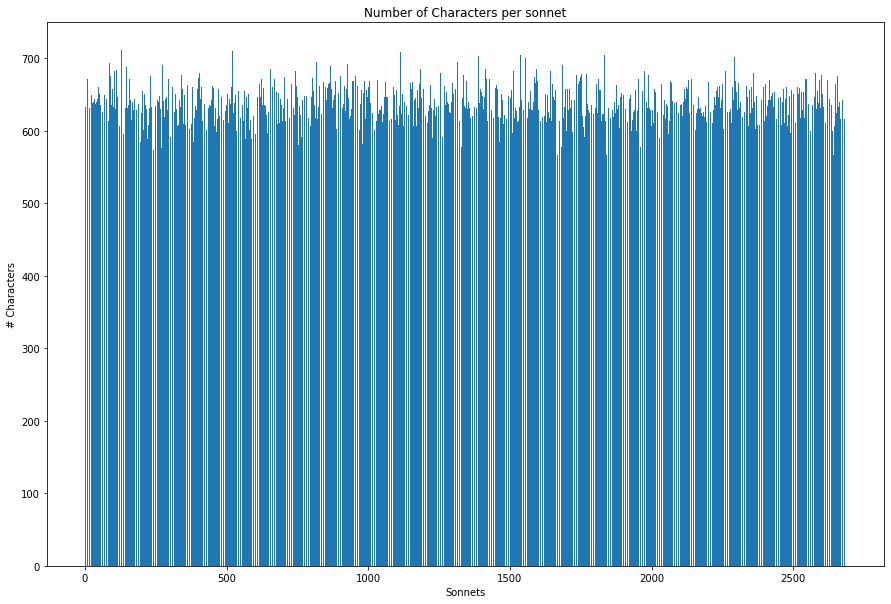

In [3]:
# Visualize sonnet character length
sonnets = data.split('\n\n')
sonnet_lens = [len(sonnet) for sonnet in sonnets]

print('Average sonnet length: %.2f characters' % np.mean(sonnet_lens))

plt.figure(figsize=(15,10))
plt.bar([i for i in range(1, len(sonnets)+1)], sonnet_lens)
plt.title('Number of Characters per sonnet')
plt.ylabel('# Characters')
plt.xlabel('Sonnets')
plt.show()

In [4]:
# Max length of each sequence
maxlen = 45

# Sample new sequence every step characters
step = 3

sentences = []
targets = []

# Loop through sonnets and create sequences and associated targets
for i in range(0, len(data) - maxlen, step):
    sentences.append(data[i:i + maxlen])
    targets.append(data[maxlen + i])

print("Number of sequences:", len(sentences))

# Grab all unique characters in corpus
chars = sorted(list(set(data)))
print("Number of unique characters:", len(chars))

# Dictionary mapping unique character to integer indices
char_indices = dict((char, chars.index(char)) for char in chars)

Number of sequences: 573562
Number of unique characters: 88


In [5]:
# Vectorize sequences and targets
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for j, char in enumerate(sentence):
        x[i, j, char_indices[char]] = 1
    y[i, char_indices[targets[i]]] = 1

print("Size of training sequences:", x.shape)
print("Size of training targets:", y.shape)

Size of training sequences: (573562, 45, 88)
Size of training targets: (573562, 88)


In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               111104    
_________________________________________________________________
dense (Dense)                (None, 88)                11352     
Total params: 122,456
Trainable params: 122,456
Non-trainable params: 0
_________________________________________________________________


In [8]:
from keras.optimizers import SGD

optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [9]:
def sample(preds, temperature=1.0):
    ''' Reweight the predicted probabilities and draw sample from newly created probability distribution. '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [9]:
epochs = 60

loss = []  # Custom history list to save model's loss

# Create directory to store generated text
base_dir = 'generated_text'
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    # Fit model for 1 epoch then generate text given a seed.
    history = model.fit(x, y, batch_size=128, epochs=1)
    loss.append(history.history['loss'][0])
    
    # Create directory to store text for each epoch
    epoch_dir = os.path.join(base_dir, 'epoch_' + str(epoch))
    if not os.path.isdir(epoch_dir):
        os.mkdir(epoch_dir)
    
    # Select a random seed text to feed into model and generate text
    start_idx = np.random.randint(0, len(data) - maxlen - 1)
    seed_text = data[start_idx:start_idx + maxlen]
    for temp in [0.2, 0.5, 1.0, 1.3]:
        generated_text = seed_text
        temp_file = 'epoch' + str(epoch) + '_temp' + str(temp) + '.txt'
        file = open(os.path.join(epoch_dir, temp_file), 'w')
        file.write(generated_text)
        
        # Predict and generate 600 characters (approx. 1 sonnet length)
        for i in range(630):
            # Vectorize generated text
            sampled = np.zeros((1, maxlen, len(chars)))
            for j, char in enumerate(generated_text):
                sampled[0, j, char_indices[char]] = 1.
            
            # Predict next character
            preds = model.predict(sampled, verbose=0)[0]
            pred_idx = sample(preds, temperature=temp)
            next_char = chars[pred_idx]
            
            # Append predicted character to seed text
            generated_text += next_char
            generated_text = generated_text[1:]
            
            # Write to text file
            file.write(next_char)
        print('Temp ' + str(temp) + " done.")
        file.close()

Epoch 1
4481/4481 [==============================] - 266s 59ms/step - loss: 2.5446
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 2
4481/4481 [==============================] - 258s 58ms/step - loss: 2.1311
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 3
4481/4481 [==============================] - 257s 57ms/step - loss: 2.0144
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 4
4481/4481 [==============================] - 254s 57ms/step - loss: 1.9264
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 5
4481/4481 [==============================] - 255s 57ms/step - loss: 1.8836
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 6
4481/4481 [==============================] - 255s 57ms/step - loss: 1.8530
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.
Epoch 7
4481/4481 [==============================] - 253s 57ms/step - loss: 1.8281
Temp 0.2 done.
Temp 0.5 done.
Temp 1.0 done.
Temp 1.3 done.

KeyboardInterrupt: 

In [ ]:
## Generating New Sonnets
Here we will pick a random seed text from the training data and predict 630 (average sonnet length) new characters using our newly trained model. We will also use a temperature of 0.5 because that gives a good balance between randomness and deterministic behaviour.

Error: Pip module debugpy is required for debugging cells. You will need to install it to debug cells.

In [13]:
def generate_sonnet(temp):
    ''' Given a temperature, generate a new sonnet '''
    start_idx = np.random.randint(0, len(data) - maxlen - 1)
    new_sonnet = data[start_idx:start_idx + maxlen]
    sys.stdout.write(new_sonnet)
    for i in range(600):
        # Vectorize generated text
        sampled = np.zeros((1, maxlen, len(chars)))
        for j, char in enumerate(new_sonnet):
            sampled[0, j, char_indices[char]] = 1.

        # Predict next character
        preds = model.predict(sampled, verbose=0)[0]
        pred_idx = sample(preds, temperature=temp)
        next_char = chars[pred_idx]

        # Append predicted character to seed text
        new_sonnet += next_char
        new_sonnet = new_sonnet[1:]

        # Print to console
        sys.stdout.write(next_char)
        sys.stdout.flush()

In [14]:
# Generate new sonnets at 0.5 temperature
generate_sonnet(0.5)

ot dumb replies unto a speaking heart 

we softbewind,andwhenthefairofway
shallretimned,andmarthedandinshouldtheread
thestreamsofthosewhattheledthestring
oftheburnthestillthetoosofcame
andwhitethisproper,theseasomefromherfair
thehinthelook,andsuchthesinglecarm
dothecart'sfirstcomeandmakethenotthegrad
andthebandermure,whosewastofpower
theseemsofstrength,thedeeperswhenthee
whoforththeinchoseofthesoundpower
been,thestorythestreamsofartsshethebreath
be,whoherself,whitethewarres,indeep
whosoultobeforthesunthe

In [16]:
# Save model
model.save('sonnet_model.h5')